In [1]:
import tensorflow as tf
from functions import *
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy.optimize import brentq
from scipy.interpolate import interp1d


2024-03-15 01:19:35.933140: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-15 01:19:35.960966: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-15 01:19:36.433865: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import gc
gc.collect()


0

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


2024-03-15 01:19:38.727899: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-03-15 01:19:38.727919: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: utkarh-nitro5
2024-03-15 01:19:38.727923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: utkarh-nitro5
2024-03-15 01:19:38.728018: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 550.54.14
2024-03-15 01:19:38.728029: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 550.54.14
2024-03-15 01:19:38.728031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 550.54.14


In [4]:
from tensorflow.keras.backend import clear_session
clear_session()

In [5]:
model = tf.keras.models.load_model('model.keras')

In [6]:
# def data_generator(file_names, labels, directory_path):
#     for file_name, label in zip(file_names, labels):
#         file_path = os.path.join(directory_path, file_name)
#         signal, sample_rate = read_flac_file(file_path)
#         lfcc_features = extract_lfcc(signal, sample_rate)
#         tensor = tf.convert_to_tensor(lfcc_features)
#         tensor = tf.expand_dims(tensor, axis=0)
#         yield tensor, label


# with open('test_preprocessed.txt', 'r') as file:
#     data = file.readlines()

# file_names_test = []
# labels_test = []

# for line in data:
#     file_name, label = line.strip().split()
#     labels_test.append(int(label))
#     file_names_test.append(file_name)

# directory_path = 'LA/ASVspoof2019_LA_eval/flac'

# # Create a dataset from the generator
# dataset_test = tf.data.Dataset.from_generator(
#     lambda: data_generator(file_names_test, labels_test, directory_path),  # Removed batch_size=32
#     output_types=(tf.float32, tf.int32),
#     output_shapes=((1, hp.F, hp.T), ())
# )

# # dataset_test = dataset_test.shuffle(buffer_size=len(file_names_test)).batch(32)


# dataset_test = dataset_test.shuffle(buffer_size=len(file_names_test))
# dataset_test = dataset_test.batch(2)
# dataset_test = dataset_test.cache()  # Cache after batching for efficient reuse
# dataset_test = dataset_test.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)



with open('test_preprocessed.txt', 'r') as file:
    data = file.readlines()
    
file_names_test = []
labels_test = []

subset_size = 10000

for line in data:
    if subset_size == 0:
        break
    subset_size -= 1
    file_name, label = line.split()
    labels_test.append(int(label))
    file_names_test.append(file_name)

tensors_test = []

directory_path = 'LA/ASVspoof2019_LA_eval/flac'

for file_name in file_names_test:
    file_path = os.path.join(directory_path, file_name)
    signal, sample_rate = read_flac_file(file_path)
    lfcc_features = extract_lfcc(signal, sample_rate)
    tensor = tf.convert_to_tensor(lfcc_features)
    tensor = tf.expand_dims(tensor, axis=0)
    tensors_test.append(tensor)


labels_test = tf.convert_to_tensor(labels_test)

dataset_test = tf.data.Dataset.from_tensor_slices((tensors_test, labels_test))

dataset_test = dataset_test.shuffle(buffer_size=len(tensors_test)).batch(32)

In [7]:
model.evaluate(dataset_test)

predictions = model.predict(dataset_test)

2024-03-15 01:20:25.756961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [10000,1,50,50]
	 [[{{node Placeholder/_0}}]]
2024-03-15 01:20:25.757432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [10000]
	 [[{{node Placeholder/_1}}]]


313/313 [==============================] - 4s 11ms/step


In [8]:
predictions = model.predict(dataset_test)


313/313 [==============================] - 4s 11ms/step


In [9]:
predictions = tf.squeeze(predictions)

In [10]:
accuracy = tf.keras.metrics.BinaryAccuracy()

accuracy = accuracy(labels_test, predictions)

print(accuracy)

tf.Tensor(0.8329, shape=(), dtype=float32)


In [11]:
# EER , t-DCF and Accuracy  

from sklearn.metrics import confusion_matrix


fpr, tpr, thresholds = roc_curve(labels_test, predictions)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

# t-DCF

def tDCF_asvspoof19(scores, labels, Pspoof=0.05, costModel=[1, 10, 1]):
    CM = confusion_matrix(labels, scores > 0.5)
    Ptar = np.sum(labels == 1) / len(labels)
    Pnon = 1 - Ptar
    
    # Handle the case when Ptar is zero
    if Ptar == 0:
        Cmiss = 0  # Set Cmiss to zero or any other appropriate value
    else:
        Cmiss = costModel[0] * Pnon * (1 - CM[1, 1]) / Ptar
        
    Cfa = costModel[1] * Ptar * CM[0, 1] / Pnon
    Cspoof = costModel[2] * Pspoof
    tDCF = Cmiss + Cfa - Cspoof
    return tDCF


tDCF = tDCF_asvspoof19(predictions, labels_test)
print('t-DCF:', tDCF)

print('EER%:', eer*100)

t-DCF: 205.801865669567
EER%: 49.848874957977394


In [12]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(labels_test, predictions > 0.5)

print('Accuracy:', accuracy)

from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(labels_test, predictions > 0.5)

confusion_matrix

# positive : 
# negative : 

Accuracy: 0.8329


array([[8256,  677],
       [ 994,   73]])

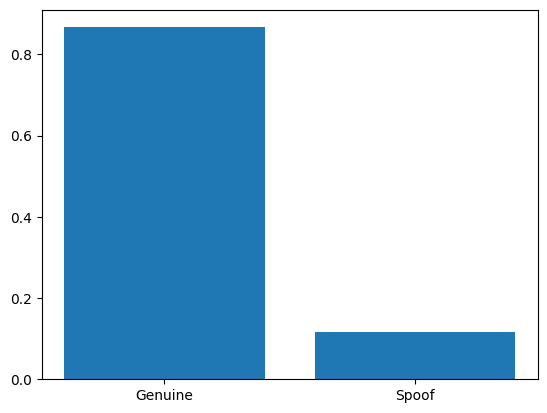

In [13]:
# plot F1 scores class wise

from sklearn.metrics import f1_score

f1_scores = f1_score(labels_test, predictions > 0.2, average=None)

f1_scores

import matplotlib.pyplot as plt

plt.bar(['Genuine', 'Spoof'], f1_scores)

plt.show()
